In [1]:

import pandas as pd
import csv
import torch
from torch import nn
import numpy as np
import re
# import spacy
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as T
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
import spacy
from spacy.lang.en import English
from emoji import UNICODE_EMOJI
from util import *
nlp = spacy.load("en_core_web_sm")

print(torch.cuda.is_available())
file_path = ''
df = pd.read_csv(file_path, sep="\t", dtype=str, keep_default_na=False, na_values=[""], quoting=csv.QUOTE_NONE)

from dateutil.parser import parse


wv_from_bin = load_embedding_model()


C:\Users\chang\.conda\envs\ebay\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


### This is what the dataset for testing looks like:

In [2]:
title_path = 'Listing_Titles.tsv'
df_title = pd.read_csv(title_path, sep="\t", dtype=str, keep_default_na=False, na_values=[""], quoting=csv.QUOTE_NONE)
df_title.head()

,Record Number,Title
0,1,LOUIS VUITTON M40096 Handbag Priscilla Multi-c...
1,2,LOUIS VUITTON Petit Noe Drawstring Shoulder Ba...
2,3,LOUIS VUITTON Damier Azur Pochette Bosphore Sh...
3,4,GUCCI Bamboo 2Way Shoulder Bag Leather Brown A...
4,5,Rank AB Vintage Gucci Sherry line PVC Leather ...


In [3]:
#Extrat info 
titles_x = []
vocab = set()
MAX_LEN = 0 
for index, row in df_title.iterrows():
    print(index,end='\r')
    sent_list = row['Title'].split(' ')
    MAX_LEN = max(MAX_LEN, len(sent_list))
    vocab.update(sent_list)
    if index== 30000:
        break


In [4]:
df = df.fillna('NAN')
print(len(df))

55121


In [5]:
### Extract training info
x = []
y = []
for i in range(1,5001):
    temp_df = df[df['Record Number']==str(i)]
    tokens = []
    tages = []
    
    for index, row in temp_df.iterrows():
        if row['Tag'] == 'NAN':
            tokens.append(row['Token'])
            tages.append(temp)
        else:
            temp =  row['Tag']
            tokens.append(row['Token'])
            tages.append(row['Tag'])

    vocab.update(tokens)
    
    # doc = nlp(sentence)
    # sentence = doc._.outcome_spellCheck
    # tokens = sentence.split(' ')
    x.append(tokens)
    y.append(tages)
    


In [6]:
# LENGTH OF THE TRAINING SET 
print(len(x))

5000


In [7]:
# MAXIMUM LENGTH OF A SENTENCE
MAX_LEN = 0 
for i in x:
    MAX_LEN = max(len(i), MAX_LEN)
MAX_LEN +=20

print(MAX_LEN)

42


In [8]:
# NUMBER OF TAGS  IS 32. 

#Digitize the tags
target = set()
for i in y:
    target.update(i)
    
target_name_to_index = {}
num = 1
for i in target:
    target_name_to_index[i]= num
    target_name_to_index[num]= i
    num+=1
print(len(target_name_to_index)/2)
target_name_to_index[0] = '[PAD]'
target_name_to_index['[PAD]'] = 0
print(len(target_name_to_index)/2)
CAT_NUM = int(len(target_name_to_index)/2)

32.0
33.0


### Reducing the dimensions of the vocabulary dimensions. 

#### Turns out, the higher the dimension the better. No need to reduce dimension. 

In [9]:
vector_space = []
NUM_COMPONENTS= 300 #you can select any number of components.


### Vocabulary cleaning
for i in vocab:
    w = vocab_clean(i)
    vector_space.append(wv_from_bin[w])


        
vector_space = np.array(vector_space)
covariance_matrix = np.cov(vector_space.T)
values, vectors = np.linalg.eig(covariance_matrix)
sorted_index = np.argsort(values)[::-1]
sorted_eigenvalue = values[sorted_index]
sorted_eigenvectors = vectors[:,sorted_index]
eigenvector_subset = sorted_eigenvectors[:,0:NUM_COMPONENTS]
print(sorted_eigenvalue)


[2.25904993 0.81696325 0.57668452 0.25574459 0.21345183 0.15410183
 0.1426699  0.11696192 0.09043778 0.08492469 0.08379914 0.0748369
 0.06838907 0.06524872 0.05731288 0.05542911 0.05328101 0.05245867
 0.04880456 0.04848949 0.04721909 0.04436738 0.04341708 0.04113247
 0.04021009 0.03872008 0.03814719 0.03545287 0.03519026 0.03386438
 0.03261184 0.03243122 0.03158918 0.03116499 0.03074222 0.03045423
 0.02936531 0.02870041 0.02803693 0.02784922 0.02665729 0.02640964
 0.0257897  0.0250006  0.02485081 0.02470358 0.02410539 0.02393676
 0.02357152 0.02328479 0.0229408  0.02257665 0.02227422 0.02200488
 0.02187531 0.02128517 0.02122395 0.02084136 0.0205761  0.02056401
 0.02025064 0.02019144 0.01972388 0.01969708 0.0193217  0.01915814
 0.01890876 0.01879868 0.01857613 0.01840255 0.01827743 0.01823555
 0.01784731 0.01768508 0.01743104 0.017356   0.01720512 0.0171467
 0.01702054 0.01690613 0.01664256 0.01652421 0.01640125 0.01634522
 0.016236   0.01620508 0.01602268 0.01593267 0.01585618 0.015778

### Training - Validation split. 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=46)

### Data Augmentation 
#### Turns out now as good of a method to use here. 

In [75]:
NUM_OF_AUG = 1000

import random
X_train_ = X_train*1
y_train_ = y_train*1
for _ in range(NUM_OF_AUG):
    index1 = random.randint(0, len(X_train)-1)
    index2 = random.randint(0, len(X_train)-1)
    index3 = random.randint(0,len(X_train[index1])-1)
    index4 = random.randint(0,len(X_train[index1])-1)
    index5 = random.randint(0,len(X_train[index2])-1)
    index6 = random.randint(0,len(X_train[index2])-1)
    
    splice1 = X_train[index1][min(index3,index4): max(index3,index4)]
    splice2  = X_train[index2][min(index5,index6): max(index5,index6)]
    X_train_.append(splice1+ splice2)
    splice1 = y_train[index1][min(index3,index4):max(index3,index4)]
    splice2  = y_train[index2][min(index5,index6): max(index5,index6)]
    y_train_.append(splice1+ splice2) 

X_train = X_train_
y_train = y_train_                           


In [11]:
## Vectorizing the data. 

x_train_vectorized = np.zeros((len(X_train),MAX_LEN,NUM_COMPONENTS))
x_original_length_train = []
for sentence_ind in range(len(X_train)):
    x_original_length_train.append(len(X_train[sentence_ind]))
    for word_ind in range(len(X_train[sentence_ind])):
        i = X_train[sentence_ind][word_ind]
        vector = wv_from_bin[vocab_clean(i)]
        # vector = vector @ eigenvector_subset
        
        x_train_vectorized[sentence_ind, word_ind] = vector

x_test_vectorized = np.zeros((len(X_test),MAX_LEN,NUM_COMPONENTS))
x_original_length_test = []
for sentence_ind in range(len(X_test)):
    x_original_length_test.append(len(X_test[sentence_ind]))
    for word_ind in range(len(X_test[sentence_ind])):
        i = X_test[sentence_ind][word_ind]
        vector = wv_from_bin[vocab_clean(i)]
        # vector = vector 
        
        x_test_vectorized[sentence_ind, word_ind] = vector
x_original_length_train = np.array(x_original_length_train)
x_original_length_test = np.array(x_original_length_test)
print(x_train_vectorized.shape)
print(x_test_vectorized.shape)

(4750, 42, 300)
(250, 42, 300)


In [12]:

y_digit_train  = np.zeros((len(X_train),MAX_LEN))
for sentence_ind in range(len(y_train)):
    for tag_ind in range(len(y_train[sentence_ind])):
        y_digit_train[sentence_ind,tag_ind] = target_name_to_index[y_train[sentence_ind][tag_ind]]
print(len(target_name_to_index)/2)
print(y_digit_train.shape)

y_digit_test  = np.zeros((len(X_test),MAX_LEN))
for sentence_ind in range(len(y_test)):
    for tag_ind in range(len(y_test[sentence_ind])):
        y_digit_test[sentence_ind,tag_ind] = target_name_to_index[y_test[sentence_ind][tag_ind]]
print(y_digit_test.shape) 



33.0
(4750, 42)
(250, 42)


In [13]:
train_dataset = []
for i in range(len(x_train_vectorized)):
    train_dataset.append((x_train_vectorized[i],
                          y_digit_train[i],
                          x_original_length_train[i]))
    
test_dataset = []
for i in range(len(x_test_vectorized)):
    test_dataset.append((x_test_vectorized[i],
                          y_digit_test[i],
                          x_original_length_test[i]))

In [14]:

class LSTMTagger(nn.Module):


    def __init__(self, embedding_dim, hidden_dim, output_size, batch_size=64):
        '''
        hidden_dim: can be anything, usually 32 or 64.
        vocab_size: vocabulary size includes an index for padding.
        output_size: We need to exclude the index for padding here.
        '''
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim

        # In this case, vocab_size is 9, embedding_dim is 6.

        # Prepare our model for minibatch based training.
        self.batch_size = batch_size
        self.ini_1 = nn.Linear(embedding_dim, 2048)
        self.ini_2 = nn.Linear(2048, 2048)
        self.ln = nn.LayerNorm(2048)
        # The linear layer that maps from hidden state space to tag space
        # output_size = tagset_size - 1 to discount padding tag.
        self.fc1= nn.Linear(hidden_dim*2, output_size)
        self.fc2 = nn.Linear(256, output_size)
        self.l_relu =  nn.LeakyReLU(0.02)

        # Note: the commented line below is what we will do to train our initial hidden state.
        
        self.lstm = nn.RNN(2048,hidden_dim,2,
                            dropout = 0.2,
                            batch_first = True,
                            bidirectional=True)

        self.dropout = nn.Dropout(0.2)
    def forward(self, sentences, X_lengths):
        '''
        Parameters
        ----------
        sentences: padded sentences tensor. Each element of the tensor is an array of words.
        X_lengths: length of sentence tensor. Each element of the tensor is the original
                   length of the unpadded sentence.
        Returns
        -------
        '''
        # Dimensions of tensors:
        # (Note that seq_len is max length)
        # Shape of embedding (embeds): batch_size, seq_len, hidden_dim
        # Shape of embedding post packing (embeds): batch_size, orig_len, hidden_dim
        # Shape of self.hidden: (num_layers*num_directions, batch_size, hidden_dim)
        # Shape of lstm_out: batch_size, seq_len, hidden_dim
        # Shape of tag_scores: batch_size, 1
        
        batch_size, seq_len,dimension = sentences.size()
        embeds = sentences
        embeds = self.ini_1(embeds)
        # embeds = self.dropout(embeds)
        embeds = self.ln(embeds)
        embeds = self.l_relu(embeds)
        
        # embeds = self.ini_2(embeds)
        # embeds = self.ln(embeds)
        # embeds = self.l_relu(embeds)
        
        # embeds = self.ini_3(embeds)
        # embeds = self.l_relu(embeds)
        
        lstm_out, _ = self.lstm(embeds)

        out = self.fc1(lstm_out)
        # out = self.ln2(out)
        # out = self.l_relu(out)
        # out = self.fc2(out)

        return out

In [15]:
BATCHSIZE = 2048
print("MAX LENTH:",MAX_LEN)
print("NUMBER OF PRINCEPLE COMPONENT:",NUM_COMPONENTS)
print("NUMBER OF CATAGORIES:",CAT_NUM)
device = torch.device("cuda")
network = LSTMTagger(embedding_dim = NUM_COMPONENTS,
                     hidden_dim  = 256,
                     output_size = CAT_NUM,
                     batch_size = BATCHSIZE)
model = network.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0022,weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=4, gamma=0.885)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCHSIZE)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=BATCHSIZE)
loss_fn =  nn.CrossEntropyLoss( reduction='sum')
def train(model, device, train_loader, optimizer, epoch, loss_fn,batch_size, log_interval=45):
    model.train()
    lose = 0 
    for batch_idx, (data, target,length) in enumerate(train_loader):
        batch_size = data.size()[0]
        data, target = data.to(device).type(torch.cuda.FloatTensor), target.to(device).type(torch.cuda.LongTensor)
        
        optimizer.zero_grad()
        
        y_pred = model.forward(data, length)
        
        loss =  loss_fn(y_pred.view(batch_size * MAX_LEN, -1),
                        target.view(batch_size * MAX_LEN) )
        loss.backward()
        optimizer.step()
        lose += loss.item()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return lose/len(train_loader.dataset)
def test(model, device, test_loader, batch_size):
    model.eval()
    loss = 0
    with torch.no_grad():
        for data, target, length  in test_loader:
            batch_size = data.size()[0]
            data, target = data.to(device).type(torch.cuda.FloatTensor), target.type(torch.cuda.LongTensor)
            y_pred = model.forward(data, length)
            test_loss = loss_fn(y_pred.view(batch_size * MAX_LEN, -1),
                        target.view(batch_size * MAX_LEN) )
            loss += test_loss.item()

    loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}\n'.format(
        loss))
    return loss
    
    
### Training. 

MAX LENTH: 42
NUMBER OF PRINCEPLE COMPONENT: 300
NUMBER OF CATAGORIES: 33


In [16]:

### Training 
train_e=[]
test_e = []
for i in range(150):
      
    train_e.append(train(model, device, train_loader,
          optimizer, i,loss_fn=loss_fn,
          batch_size=BATCHSIZE))
          
    test_e.append(test(model, device, test_loader, batch_size=BATCHSIZE))
    scheduler.step()


RuntimeError: CUDA out of memory. Tried to allocate 3.75 GiB (GPU 0; 8.00 GiB total capacity; 4.43 GiB already allocated; 0 bytes free; 7.21 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [20]:
torch.cuda.empty_cache()

6.940736293792725


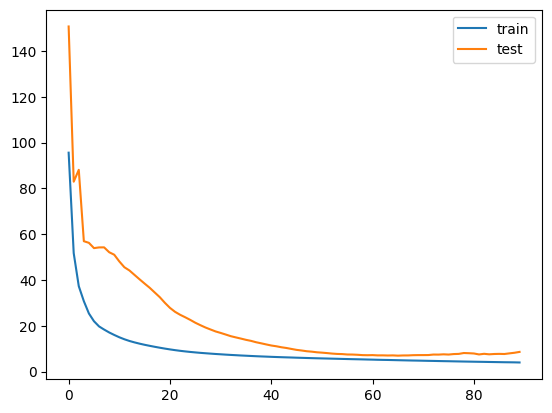

In [ ]:
### Training Loss curve
import matplotlib.pyplot as plt
plt.plot(train_e, label= 'train')
plt.plot(test_e, label = 'test')
plt.legend()
print(min(test_e))

In [70]:
def predict_tag(sample):
    sample = [vocab_clean(word) for word in sample]
    length = [len(sample)]

    ini = np.zeros((1,MAX_LEN,NUM_COMPONENTS))
    vector_sample = np.array([ wv_from_bin[i] for i in sample])
    vector_sample = vector_sample
    ini[0,:vector_sample.shape[0],:NUM_COMPONENTS] = vector_sample
    sample = torch.tensor(ini).to(device).type(torch.cuda.FloatTensor)

    optimizer.zero_grad()
    model.eval()        
    y_pred = model.forward(sample, length)
    y_pred =y_pred.view(1,  MAX_LEN, CAT_NUM,-1)
    y_pred = y_pred.cpu()
    y_pred = y_pred.detach().numpy()
    y_pred = y_pred[0]
    y_pred = y_pred.squeeze()
    y_pred = y_pred.argmax(axis = 1)
    out_list = []
    for i in y_pred:
        if target_name_to_index[i] != '[PAD]':
            out_list.append(target_name_to_index[i])
        else:
            break
    return out_list


In [71]:
def tokenizer(title):
    tokens = title.split(' ')
    out = []
    for token in tokens:
        out.append(token)
    return out

tokenizer("the women 's handbag")

['the', 'women', "'s", 'handbag']

In [72]:
submission = {'Record number':[], "Aspect Name":[], "Aspect Value":[]}
for num in range(5001,30001):
    print(int(((num-5000)/(30000-5000))*100), end = '\r')
    tokens = tokenizer(df_title['Title'][num-1])

    out_list=predict_tag(tokens)
    temp=None
    jump = False
    for i in range(min(len(out_list),len(tokens))):
        # if tokens[i] == 'strap' or tokens[i] == 'strapdrop':
            # found = False
            # index = i
            # while index != 0:
            #     if tokens[index].isnumeric():
            #         submission['Record number'].append(num)
            #         submission['Aspect Name'].append('Strap Drop')
            #         submission['Aspect Value'].append(tokens[i])                    
            #         found = True
            #         break
            #     index-=1
            # if found:
            #     continue
        if jump:
            jump = False 
            continue
        if tokens[i].lower() == 'hand' and i != len(tokens)-1 and   tokens[i+1].lower() == 'bag':
            jump = True
            submission['Record number'].append(num)
            submission['Aspect Name'].append('Type')
            submission['Aspect Value'].append(tokens[i] + ' ' + tokens[i+1])
            continue
        
        
        if tokens[i].lower() == 'cc' and i != len(tokens)-1 and   tokens[i+1].lower() == 'logo':
            jump = True
            submission['Record number'].append(num)
            submission['Aspect Name'].append('Accents')
            submission['Aspect Value'].append(tokens[i] + ' ' + tokens[i+1])
            continue
        if tokens[i].lower() == 'leather' and i != 0 and   out_list[i-1] == 'Material':
            submission['Aspect Value'][-1] = tokens[i-1] + ' ' + tokens[i]
            continue
        if out_list[i] == temp and (out_list[i] == 'Model' or
                                    out_list[i] == 'Brand' or 
                                    out_list[i] == 'Theme' or
                                    out_list[i] == 'Trim Material' or
                                    out_list[i] == 'Strap Drop' or 
                                    out_list[i] == 'Character' or
                                    out_list[i] == 'Character Family' or
                                    out_list[i] == 'Features' or
                                    out_list[i] == 'Handle Drop' or
                                    out_list[i] == 'Shoulder Strap' or
                                    out_list[i] == 'Hardware Material' or
                                    out_list[i] =='Handle Style' or
                                    out_list[i] =='Measurement, dimension' or
                                    out_list[i] == 'Pocket Type' or
                                    out_list[i] == 'Product Line'):
            prev_name = submission['Aspect Value'][-1]
            submission['Record number'].append(num)
            # submission['Aspect Name'].append(out_list[i])
            submission['Aspect Value'][-1] = prev_name + ' ' + tokens[i]
        else:
            submission['Record number'].append(num)
            submission['Aspect Name'].append(out_list[i])
            submission['Aspect Value'].append(tokens[i])
            temp = out_list[i]
submission= pd.DataFrame(submission)        


In [659]:
submission = {'Record number':[], "Aspect Name":[], "Aspect Value":[]}
for num in range(5001,30000):
    print(int(((num-5000)/(30000-5000))*100), end = '\r')
    tokens = tokenizer(df_title['Title'][num-1])

    out_list=predict_tag(tokens)
    temp=None
    for i in range(min(len(out_list),len(tokens))):
            submission['Record number'].append(num)
            submission['Aspect Name'].append(out_list[i])
            submission['Aspect Value'].append(tokens[i])
            temp = out_list[i]
submission= pd.DataFrame(submission)


In [73]:
submission.to_csv('submission.csv', sep ='\t', index = False,header=None)

### Result showcase. 

In [666]:
num = 280021
print(df_title['Title'][num])
tokens = tokenizer(df_title['Title'][num])

print(tokens)
out_list=predict_tag(tokens)
print(out_list)

Ladies Rowallan Soft Tan Real Leather Over Body / shoulder Bag
['Ladies', 'Rowallan', 'Soft', 'Tan', 'Real', 'Leather', 'Over', 'Body', '/', 'shoulder', 'Bag']
['Department', 'Model', 'Features', 'Color', 'No Tag', 'Material', 'Closure', 'Type', 'No Tag', 'Type', 'Type']


In [258]:
test_ = submission[submission['Aspect Name']=='Strap Drop']
test_.to_csv('test.csv')
test_


,Record number,Aspect Name,Aspect Value
1454,5248,Strap Drop,strap
103758,21461,Strap Drop,strap
120985,24208,Strap Drop,strap
145899,28092,Strap Drop,strap
